# Open Notebook directly in Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/Nicolepcx/quantminds_agents_talk/blob/main/lats.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Language Agent Tree Search

[Language Agent Tree Search](https://arxiv.org/abs/2310.04406) (LATS), by Zhou, et. al, is a general LLM agent search algorithm that combines reflection/evaluation and search (specifically monte-carlo trees search) to get achieve better overall task performance compared to similar techniques like ReACT, Reflexion, or Tree of Thoughts.

![Graph](https://drive.google.com/uc?export=view&id=1u-zq_WQcuY6FlPB7-VJDCywix45P2W2J)

It has four main steps:

1. Select: pick the best next actions based on the aggregate rewards from step (2). Either respond (if a solution is found or the max search depth is reached) or continue searching.
2. Expand and simulate: select the "best" 5 potential actions to take and execute them in parallel.
3. Reflect + Evaluate: observe the outcomes of these actions and score the decisions based on reflection (and possibly external feedback)
4. Backpropagate: update the scores of the root trajectories based on the outcomes.

# Dependencies

Install `langgraph` (for the framework), `langchain_openai` (for the LLM), and `langchain` + `tavily-python` (for the search engine).

We will use tavily search as a tool. You can get an API key [here](https://app.tavily.com/sign-in) or replace with a different tool of your choosing.

In [22]:
!pip install langchain langgraph langchain_openai langchain_core -qqq
!pip install tavily-python langchain_community python-dotenv -qqq

# Imports

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import os
import math
import json
from collections import deque, defaultdict
from typing import Optional, List
from typing_extensions import TypedDict

from IPython.display import Image

from langchain_openai import ChatOpenAI

from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import chain as as_runnable
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_core.prompt_values import ChatPromptValue
from langchain_core.runnables import RunnableConfig


from dotenv import load_dotenv
load_dotenv()




True

In [25]:
# API-Access

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

# Init LLM

In [26]:
llm = ChatOpenAI(model="gpt-4o")

# Graph State

LATS is based on a (greedy) Monte-Carlo tree search. For each search steps, it picks the node with the highest "upper confidence bound", which is a metric that balances exploitation (highest average reward) and exploration (lowest visits). Starting from that node, it generates N (5 in this case) new candidate actions to take, and adds them to the tree. It stops searching either when it has generated a valid solution OR when it has reached the maximum number of rollouts (search tree depth).

Your LangGraph state will be composed of two items:
1. The root of the search tree
2. The user input

## Reflection

The reflection chain will score agent outputs based on the decision and the tool responses.
We will call this within the other two nodes.

In [27]:
class Reflection(BaseModel):
    reflections: str = Field(
        description="The critique and reflections on the sufficiency, superfluency, and general quality of the response."
    )
    score: int = Field(
        description="Score from 0-10 on the quality of the candidate response.",
        gte=0,
        lte=10,
    )
    found_solution: bool = Field(
        description="Whether the response has fully solved the question or task."
    )

    def as_message(self):
        return HumanMessage(
            content=f"Reasoning: {self.reflections}\nScore: {self.score}"
        )

    @property
    def normalized_score(self) -> float:
        """Return a normalized score between 0 and 1."""
        return self.score / 10.0

    @classmethod
    def from_response(cls, tool_choices, inputs):
        """Initialize Reflection instance directly from parsed tool response."""
        reflection = tool_choices[0]
        if not isinstance(inputs["candidate"][-1], AIMessage):
            reflection.found_solution = False
        return reflection

# Configure Prompt Template for Reflection
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Reflect and grade the assistant response to the user question below.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="candidate"),
    ]
)

# Reflection Chain Construction
reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice="Reflection").with_config(
        run_name="Reflection"
    )
    | PydanticToolsParser(tools=[Reflection])
)

@as_runnable
def reflection_chain(inputs) -> Reflection:
    tool_choices = reflection_llm_chain.invoke(inputs)
    return Reflection.from_response(tool_choices, inputs)


In [28]:
class Node:
    __slots__ = (
        "messages", "parent", "children", "value", "visits", "reflection", "depth",
        "_is_solved"
    )

    def __init__(
        self,
        messages: List[BaseMessage],
        reflection: 'Reflection',
        parent: Optional["Node"] = None,
    ):
        self.messages = messages
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f"<Node value={self.value}, visits={self.visits},"
            f" solution={self.messages} reflection={self.reflection}/>"
        )

    @property
    def is_solved(self):
        return self._is_solved

    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child(self):
        if not self.children:
            return None
        return max(self.children, key=lambda child: child.upper_confidence_bound())

    @property
    def best_child_score(self):
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        if self.children:
            return 1 + max(child.height for child in self.children)
        return 1

    def upper_confidence_bound(self, exploration_weight=1.0):
        if self.parent is None:
            raise ValueError("Cannot obtain UCT from root node")
        if self.visits == 0:
            return self.value
        average_reward = self.value / self.visits
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)
        return average_reward + exploration_weight * exploration_term

    def backpropagate(self, reward: float):
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent

    def get_messages(self, include_reflections: bool = True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]
        return self.messages

    def get_trajectory(self, include_reflections: bool = True) -> List[BaseMessage]:
        messages = []
        node = self
        while node:
            messages.extend(
                node.get_messages(include_reflections=include_reflections)[::-1]
            )
            node = node.parent
        return messages[::-1]

    def _get_all_children(self):
        all_nodes = []
        nodes = deque([self])
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            nodes.extend(node.children)
        return all_nodes

    def get_best_solution(self):
        all_nodes = [self] + self._get_all_children()
        best_node = max(
            all_nodes,
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,
        )
        return best_node

    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent


#### The graph state itself

The main component is the tree, represented by the root node.

In [29]:
class TreeState(TypedDict):
    # The full tree
    root: Node
    # The original input
    input: str

# Define Language Agent

Our agent will have three primary LLM-powered processes:
1. Reflect: score the action based on the tool response.
2. Initial response: to create the root node and start the search.
3. Expand: generate 5 candidate "next steps" from the best spot in the current tree

For more "Grounded" tool applications (such as code synthesis), you could integrate code execution into the reflection/reward step. This type of external feedback is very useful (though adds complexity to an already complicated example notebook).

#### Tools

For our example, we will give the language agent a search engine.

In [30]:
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_executor = ToolExecutor(tools=tools)

## Initial Response

We start with a single root node, generated by this first step. It responds to the user input either with a tool invocation or a response.

In [31]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


initial_answer_chain = prompt_template | llm.bind_tools(tools=tools).with_config(
    run_name="GenerateInitialCandidate"
)


parser = JsonOutputToolsParser(return_id=True)

### Starting Node

We will package up the candidate generation and reflection in a single node of our graph. This is represented by the following function:

In [32]:
# Define the node we will add to the graph
def generate_initial_response(state: TreeState) -> dict:
    """Generate the initial candidate response."""
    res = initial_answer_chain.invoke({"input": state["input"]})
    parsed = parser.invoke(res)
    tool_responses = tool_executor.batch(
        [ToolInvocation(tool=r["type"], tool_input=r["args"]) for r in parsed]
    )
    output_messages = [res] + [
        ToolMessage(content=json.dumps(resp), tool_call_id=tool_call["id"])
        for resp, tool_call in zip(tool_responses, parsed)
    ]
    reflection = reflection_chain.invoke(
        {"input": state["input"], "candidate": output_messages}
    )
    root = Node(output_messages, reflection=reflection)
    return {
        **state,
        "root": root,
    }

## Candidate Generation

The following code prompts the same LLM to generate N additional candidates to check.

In [33]:
def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree, generate N candidates for the next step."""
    root = state["root"]
    best_candidate: Node = root.best_child if root.children else root
    messages = best_candidate.get_trajectory()
    # Generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke(
        {"input": state["input"], "messages": messages}, config
    )
    parsed = parser.batch(new_candidates)
    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]
    tool_responses = tool_executor.batch(
        [
            ToolInvocation(tool=tool_call["type"], tool_input=tool_call["args"])
            for _, tool_call in flattened
        ]
    )
    collected_responses = defaultdict(list)
    for (i, tool_call), resp in zip(flattened, tool_responses):
        collected_responses[i].append(
            ToolMessage(content=json.dumps(resp), tool_call_id=tool_call["id"])
        )
    output_messages = []
    for i, candidate in enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])

    # Reflect on each candidate
    # For tasks with external validation, you can add it here
    reflections = reflection_chain.batch(
        [{"input": state["input"], "candidate": msges} for msges in output_messages],
        config,
    )
    # Grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]
    best_candidate.children.extend(child_nodes)
    # We have already extended the tree directly, so we just return the state
    return state

In [34]:
# Centralized Configuration for LATS with MCTS
config = {
    "candidate_count": 5,  # N - Number of candidate generations
    "max_depth": 5,        # Max rollout depth for tree search
}

# Generate Candidates with Centralized Configuration
def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config.get("candidate_count", 5)  # Retrieve from centralized config
    bound_kwargs = llm.bind_tools(tools=tools).kwargs

    # Generate candidates with preconfigured settings
    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config["callbacks"],
        run_name="GenerateCandidates",
        **bound_kwargs,
    )
    return [gen.message for gen in chat_result.generations[0]]

# Build the StateGraph for MCTS with Centralized Depth Control
from typing import Literal
from langgraph.graph import END, StateGraph, START

def should_loop(state: TreeState) -> Literal["expand", "__end__"]:
    """Determine whether to continue the tree search based on centralized config."""
    root = state["root"]
    if root.is_solved:
        return END
    if root.height > config["max_depth"]:  # Use centralized depth limit
        return END
    return "expand"

# Initialize the StateGraph with Tree Nodes
builder = StateGraph(TreeState)
builder.add_node("start", generate_initial_response)
builder.add_node("expand", expand)
builder.add_edge(START, "start")

# Set conditional edges based on should_loop function
builder.add_conditional_edges("start", should_loop)
builder.add_conditional_edges("expand", should_loop)

# Compile the graph
graph = builder.compile()

# Usage of expansion chain with centralized configuration
expansion_chain = prompt_template | generate_candidates


#### Candidate generation node

We will package the candidate generation and reflection steps in the following "expand" node.
We do all the operations as a batch process to speed up execution.

## Plot Graph

With those two nodes defined, we are ready to define the graph. After each agent step, we have the option of finishing.

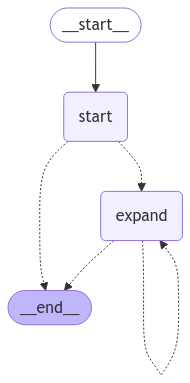

In [35]:
Image(graph.get_graph().draw_mermaid_png())

#  Run LATS

In [36]:
def run_lats(graph, question: str):
    """
    Executes the graph query with the provided question, streams the results,
    and retrieves the best solution's trajectory.

    Parameters:
    - graph: The LangGraph StateGraph instance.
    - question (str): The query or prompt to feed into the graph.

    Returns:
    - str: The content of the best trajectory's final message.
    """
    last_step = None
    for step in graph.stream({"input": question}):
        last_step = step
        step_name, step_state = next(iter(step.items()))
        print(step_name)
        print("rolled out:", step_state["root"].height)
        print("---")

    if last_step and "expand" in last_step:
        solution_node = last_step["expand"]["root"].get_best_solution()
        best_trajectory = solution_node.get_trajectory(include_reflections=False)
        return best_trajectory[-1].content
    else:
        print("No solution found or graph did not expand as expected.")
        return None


In [38]:
question = """
            Generate a table with the top five AI companies with their annual
            revenue and their flagship Foundation Model.
            """
best_solution_content = run_lats(graph, question)
if best_solution_content:
    print("Best solution content:", best_solution_content)


start
rolled out: 1
---
expand
rolled out: 2
---
expand
rolled out: 3
---
Best solution content: You're correct in pointing out the inaccuracies and assumptions in the previous response. Here's a revised table, acknowledging the challenges in obtaining specific revenue figures for AI divisions within larger companies:

| Company      | Estimated Revenue (General) | Flagship Foundation Model |
|--------------|-----------------------------|---------------------------|
| OpenAI       | N/A                         | GPT-4                     |
| Google (DeepMind) | Part of Alphabet's $1.88 trillion market cap | Gemini                      |
| Microsoft    | N/A                         | Azure AI                  |
| IBM          | N/A                         | Granite                   |
| Anthropic    | N/A                         | Claude                    |

### Notes:
- **Revenue Figures**: Specific annual revenue for AI divisions like OpenAI, Google's DeepMind, and others are often n